In [75]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import signal

from convnwb.io import make_session_name
from spiketools.spatial.information import compute_spatial_information
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot
from spiketools.plts.spatial import plot_heatmap, plot_positions, create_heatmap_title
from spiketools.plts.annotate import add_vlines, color_pvalue
from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates
from spiketools.utils.run import create_methods_list



In [220]:
import sys
sys.path.append('../code')
from models import  create_df_place, create_df_place_cond, fit_anova_place, fit_anova_place_cond
from utils import compute_firing_rates, compute_trial_firing_rates, compute_t_occupancy, circular_shuffle_unit_fr,get_values_by_times
sys.path.append('../scripts')
from settings import METHODS, SURROGATES



In [221]:

from scipy.io import loadmat
data = loadmat('/Users/weijiazhang/Data/Train/data_matfile/R1219C_0_train_events.mat')
behavioral_data = pd.read_csv('/Users/weijiazhang/Data/Train/events/events.csv')


## Settings 

In [222]:
epochSize = 0.1
numBins = 40
kernelSize = 8
numBinsPos = 40
numBinsSpeed = 25
units = 19

In [223]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : '0'    
}

experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219C_session_0'

In [224]:
# Get behavioral data
df = pd.DataFrame(data['events']['events'][0][0][0])
# Convert object columns to string type
str_cols = ['subj', 'object','timesfile']
for col in str_cols:
    df[col] = df[col].str[0].astype(str)
# Convert numeric columns to appropriate types
int_cols = ['session', 'trialNum', 'blockType', 'driveType'] 
float_cols = ['object_position', 'response_position', 'response_mstime', 'timesoffset','mstime', 'position','speed']
for col in int_cols:
    df[col] = df[col].str[0].astype(int)
for col in float_cols:
    df[col] = df[col].str[0].astype(float)


## Extract Spikes

In [225]:

# Access spikeTimes from the nested structured array
spike_times = data['events']['spikeData'][0][0]['spikeTimes'][0][0][0][units]
print("Spike times shape:", spike_times.shape)
spike_times


Spike times shape: (1963, 1)


array([[9.72000000e+02],
       [5.03536667e+03],
       [6.39073333e+03],
       ...,
       [2.33852447e+06],
       [2.33940327e+06],
       [2.33970867e+06]])

In [226]:
spike_name = data['events']['spikeData'][0][0]['spikeNames'][0][0][0][units]
print(f"Spike name: {spike_name}")

# Create DataFrame of electrode labels and clean up types
elec_labels = pd.DataFrame(data['events']['spikeData'][0][0]['elecLabels'][0][0][0])
elec_labels['ElectrodeID'] = elec_labels['ElectrodeID'].str[0].astype(int)
elec_labels['Label'] = elec_labels['Label'].str[0].astype(str)
elec_labels = elec_labels[elec_labels['Label'] != 'ainp1']

# Find matching electrode label
label = None
for idx, elec_id in enumerate(elec_labels['ElectrodeID'].values):
    if str(elec_id) in str(spike_name):
        label = elec_labels['Label'].iloc[idx]
        break

Spike name: ['NSX124_2']


## Extract Firing Rates

In [227]:
events_fr = data['events']['fr'][0][0]
events_fr.shape

fr = events_fr[:,units]
fr.shape

(7654,)

## Extract Position Data

In [228]:
behavioral_data['position']

0      -33.970167
1      -33.835283
2      -33.584817
3      -33.217183
4      -32.736283
          ...    
7649    29.248400
7650    30.118150
7651    30.887517
7652    31.569600
7653    32.174733
Name: position, Length: 7654, dtype: float64

In [242]:
positions = behavioral_data['position']
positions = (positions + 34) / 68  # Normalize to 0-1 range
positions[positions < 0] = 0  # Clip values below 0
positions[positions > 1] = 1 
positions 

ptimes = behavioral_data['timesoffset']

In [243]:
edges_pos = np.linspace(0, 100, numBinsPos+1)
pos_bin = np.digitize(positions*100, edges_pos)
count, _ = np.histogram(positions*100, bins=edges_pos)

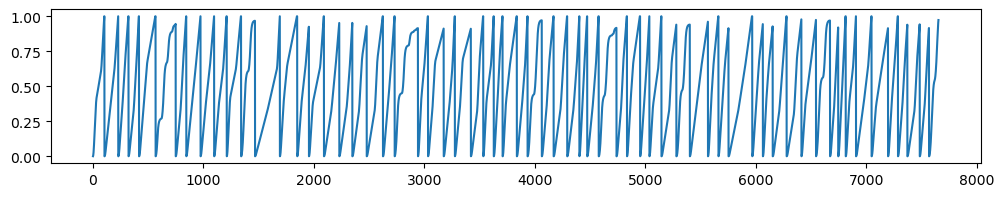

In [244]:
fig,ax = plt.subplots(1,1,figsize=(12,2))
plt.plot(positions)

In [245]:
speeds = np.array(behavioral_data['speed'])
bad = speeds < 2

bad.shape


(7654,)

In [246]:
behavioral_data['timesoffset']

0       1.169224e+05
1       1.170224e+05
2       1.171224e+05
3       1.172224e+05
4       1.173224e+05
            ...     
7649    2.284070e+06
7650    2.284170e+06
7651    2.284270e+06
7652    2.284370e+06
7653    2.284470e+06
Name: timesoffset, Length: 7654, dtype: float64

In [251]:
spike_times

array([[9.72000000e+02],
       [5.03536667e+03],
       [6.39073333e+03],
       ...,
       [2.33852447e+06],
       [2.33940327e+06],
       [2.33970867e+06]])

In [250]:
#spikes = threshold_spikes_by_values(spikes_or, ptimes, speed, min_speed)
spike_positions,indx = get_values_by_times(ptimes, positions, spike_times,time_threshold = .1)
spike_t = ptimes[indx]

TypeError: The parameter value should have type: ['int', 'float', 'numpy.int64', 'numpy.float64'].

In [247]:
spike_index = np.arange(1, spike_times.shape[0] + 1, dtype=np.uint32)
spike_index.shape
spike_in_bin = []
spike_index_within_bin = []

right_edges =behavioral_data['timesoffset']+99
print(right_edges)



0       1.170214e+05
1       1.171214e+05
2       1.172214e+05
3       1.173214e+05
4       1.174214e+05
            ...     
7649    2.284169e+06
7650    2.284269e+06
7651    2.284369e+06
7652    2.284469e+06
7653    2.284569e+06
Name: timesoffset, Length: 7654, dtype: float64


In [248]:
for k in range(len(behavioral_data['mstime'])):
    mask = (spike_times >= behavioral_data['timesoffset'][k]) & (spike_times <= right_edges[k])
    spike_indices = np.where(mask)[0]  # Get the indices where mask is True
    
    # Create bin edges from start to end time
    bin_edges = np.arange(behavioral_data['timesoffset'][k], right_edges[k] + 1)
    # Find indices where spikes occur within the bin
    hist_counts, _ = np.histogram(spike_times, bins=bin_edges)
    spike_index_within_bin.append(np.where(hist_counts > 0)[0])


In [241]:
ptimes = behavioral_data['timesoffset']

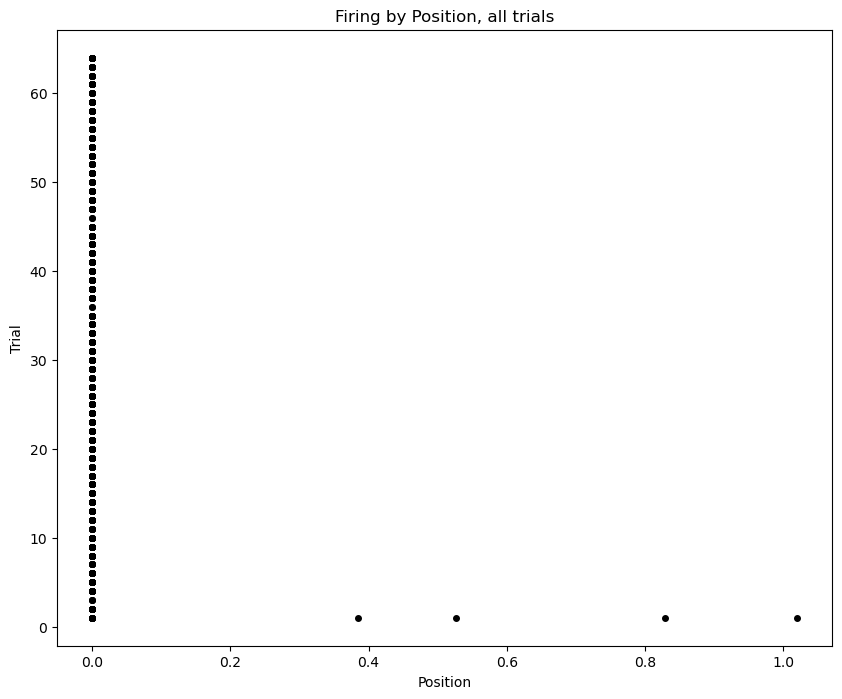

In [238]:
# Define bin edges for each event
right_edges = behavioral_data['timesoffset'].values + 99  # Gets the right edges of every bin

# Initialize containers for spike indices
spike_times_array = np.array(spike_times)
spikes_in_bin = []
spike_index_within_bin = []

# Find spikes within each time bin
for k in range(len(behavioral_data)):
    # Find spikes that fall within this time bin
    left_edge = behavioral_data.iloc[k]['timesoffset']
    right_edge = right_edges[k]
    mask = (spike_times_array >= left_edge) & (spike_times_array <= right_edge)
    selected_spikes = np.where(mask)[0]
    spikes_in_bin.append(selected_spikes)
    
    # Find indices within the bin (relative position in 100ms window)
    bin_edges = np.linspace(left_edge, right_edge, 101)  # 100 bins within the window
    hist_counts, _ = np.histogram(spike_times_array[mask], bins=bin_edges)
    spike_index_within_bin.append(np.where(hist_counts > 0)[0])

# Get trial information
trial_nums = behavioral_data['trialNum'].values

# Find bins where trial changes
trial_change = np.where(np.diff(np.concatenate([[1], trial_nums])))[0]

# Set up indices for upsampling position data
left_upsample_idx = np.concatenate([[0], trial_change])+1
right_upsample_idx = np.concatenate([trial_change - 1, [len(positions) - 1]])+1

position_upsample = []

# Process each segment defined by left and right indices
for k in range(len(left_upsample_idx)):
    # Extract the position segment and resample it to 100 points
    segment = positions[left_upsample_idx[k]:right_upsample_idx[k]]
    # Using scipy's resample function to get 100 points
    from scipy import signal
    resampled = signal.resample(segment, 100)
    position_upsample.append(resampled)

# Concatenate all resampled segments
pos_for_resample = np.concatenate(position_upsample)

# Clip values greater than 68
pos_for_resample[pos_for_resample > 68] = 68

# Create a matrix of the correct size (100 x 7654)
# Instead of reshaping, we'll create a new array of the right size
full_pos_for_resample = np.zeros((100, len(positions)))

# Fill in the available data
# This assumes we have fewer resampled points than positions
# and we're placing them at the beginning
num_cols = min(len(pos_for_resample) // 100, len(positions))
for i in range(num_cols):
    full_pos_for_resample[:, i] = pos_for_resample[i*100:(i+1)*100]

# Replace the original array with the correctly sized one
pos_for_resample = full_pos_for_resample
pos_for_resample.shape

# Get spike positions
spike_position = [[] for _ in range(len(positions))]
for k in range(len(positions)):
    # Check if position is decreasing (problem with upsampling)
    if np.sum(np.diff(pos_for_resample[:, k])) < 0:
        pos_for_resample[:, k] = np.nan
    
    # Get positions for spikes in this bin
    if len(spike_index_within_bin[k]) > 0:
        indices = spike_index_within_bin[k].astype(int)
        valid_indices = indices[indices < 100]  # Ensure indices are within bounds
        if len(valid_indices) > 0:
            spike_position[k] = pos_for_resample[valid_indices, k]

# Plotting
to_plot = 1
if to_plot == 1:
    spikes_positions_trials = [[] for _ in range(64)]
    plt.figure(figsize=(10, 8))
    
    trial_idx = np.concatenate([[0], trial_change, [len(spike_position) - 1]])
    
    for num_trial in range(64):
        if num_trial < len(trial_idx) - 1:
            start_idx = trial_idx[num_trial]
            end_idx = trial_idx[num_trial + 1]
            
            # Collect spike positions for this trial
            trial_spikes = []
            for pos in spike_position[start_idx:end_idx+1]:
                if len(pos) > 0:
                    trial_spikes.extend(pos)
            
            spikes_positions_trials[num_trial] = trial_spikes
            
            # Plot spikes for this trial
            if len(trial_spikes) > 0:
                plt.plot(trial_spikes, [num_trial + 1] * len(trial_spikes), 'k.', markersize=8)
    
    plt.title('Firing by Position, all trials')
    plt.ylabel('Trial')
    plt.xlabel('Position')
    
    # Save figure
    plot_filename = f"{session_name}_Raster_all_trials.png"
    plt.savefig(plot_filename)



In [204]:
len(left_upsample_idx)
len(right_upsample_idx)

64

In [219]:
import numpy as np
from scipy.signal import resample

position = behavioral_data['position']+34


position_upsample = []
for k in range(len(left_upsample_idx)):
    segment = position[left_upsample_idx[k]:right_upsample_idx[k]]
    print(left_upsample_idx[k],right_upsample_idx[k])
    # Resample the segment to 100 points
    resampled_segment = resample(segment, 100)
    if k == 0:
        position_upsample = resampled_segment
    else:
        position_upsample = np.concatenate((position_upsample, resampled_segment))
    print(f"Original length: {len(segment)}, Resampled length: {len(resampled_segment)}")


# # Flatten to a 1D array of length (100 * len(position))
# pos_for_resample = np.concatenate(position_upsample)

# # Clip values above 68
# pos_for_resample = np.clip(pos_for_resample, None, 68)

# # Reshape to (100, len(position))
# pos_resample = pos_for_resample.reshape(100, len(position))

len(position_upsample)


1 104
Original length: 103, Resampled length: 100
105 229
Original length: 124, Resampled length: 100
230 322
Original length: 92, Resampled length: 100
323 417
Original length: 94, Resampled length: 100
418 567
Original length: 149, Resampled length: 100
568 749
Original length: 181, Resampled length: 100
750 845
Original length: 95, Resampled length: 100
846 974
Original length: 128, Resampled length: 100
975 1097
Original length: 122, Resampled length: 100
1098 1211
Original length: 113, Resampled length: 100
1212 1341
Original length: 129, Resampled length: 100
1342 1467
Original length: 125, Resampled length: 100
1468 1692
Original length: 224, Resampled length: 100
1693 1849
Original length: 156, Resampled length: 100
1850 1955
Original length: 105, Resampled length: 100
1956 2091
Original length: 135, Resampled length: 100
2092 2230
Original length: 138, Resampled length: 100
2231 2348
Original length: 117, Resampled length: 100
2349 2478
Original length: 129, Resampled length: 

6400

In [211]:
% In MATLAB, this would be:
% position(left_upsample_idx(k):right_upsample_idx(k))
% 
% This is accessing elements of the 'position' array from index left_upsample_idx(k) 
% to right_upsample_idx(k) inclusive. In Python, the equivalent would be:
position[left_upsample_idx[k]:right_upsample_idx[k]]

UsageError: Line magic function `%` not found.


In [192]:
len(left_upsample_idx)

64